In [ ]:
import os
import glob
import random
import shutil
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import tensorflow as tf
from keras.models import Sequential
!pip install split-folders
import splitfolders 

In [ ]:
import glob
import os
from tqdm import tqdm
from PIL import  Image, ImageFile
from joblib  import Parallel, delayed
import shutil
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive #comment out this line if you are using Colab
drive.mount('/content/drive') #comment out this line if you are using Colab

#############################################################################
# TODO: Edit the path to your assignment folder                             #
#############################################################################
main_path = "/content/drive/MyDrive/cive_project_data"
os.chdir(main_path)
#############################################################################

#do not edit this line

Mounted at /content/drive


In [ ]:
train_data = []
train_label = []
test_data = []
test_label = []
for label in range(2):
    for c in range(1, 7):
        if label == 0:
            ls = glob.glob('/content/drive/MyDrive/cive_project_data/Class{}/*.png'.format(c))
            random.shuffle(ls)
        else:
            ls = glob.glob('/content/drive/MyDrive/cive_project_data/Class{}_def/*.png'.format(c))
            random.shuffle(ls)
        if label == 0:
            train = random.sample(ls, 700)
            train_data.append(train)
            train_label.append([0] * 700)
        else:
            train = random.sample(ls, 105)
            train_data.append(train)
            train_label.append([1] * 105)
            
        test = list(set(ls) - set(train))
        test_data.append(test)
        if label == 0:
          test_label.append([0] * len(test))
        else:
          test_label.append([1] * len(test))

#ls = glob.glob('/content/drive/MyDrive/cive_project_data/Class{}_def/*.png'.format(c))
for c in range(1, 7):
     ls = glob.glob('/content/drive/MyDrive/cive_project_data/Class{}_def'.format(c))[0]
for num, img_path in enumerate(os.listdir(ls)):
       src_dir = os.path.join(ls, img_path)
       dst_dir = os.path.join('/content/drive/MyDrive/training_dataset/defective/','class'+str(c)+'_'+str(num+1)+'.png')
       shutil.copyfile(src_dir, dst_dir)

"train_data = []\ntrain_label = []\ntest_data = []\ntest_label = []\nfor label in range(2):\n    for c in range(1, 7):\n        if label == 0:\n            ls = glob.glob('/content/drive/MyDrive/cive_project_data/Class{}/*.png'.format(c))\n            random.shuffle(ls)\n        else:\n            ls = glob.glob('/content/drive/MyDrive/cive_project_data/Class{}_def/*.png'.format(c))\n            random.shuffle(ls)\n        if label == 0:\n            train = random.sample(ls, 400)\n            train_data.append(train)\n            train_label.append([0] * 400)\n        else:\n            train = random.sample(ls, 105)\n            train_data.append(train)\n            train_label.append([1] * 105)\n            \n        test = list(set(ls) - set(train))\n        test_data.append(test)\n        if label == 0:\n          test_label.append([0] * len(test))\n        else:\n          test_label.append([1] * len(test))\n\n#ls = glob.glob('/content/drive/MyDrive/cive_project_data/Class{}_def/

In [ ]:
input_folder  = '/content/drive/MyDrive/training_dataset'
output_folder = '/content/drive/MyDrive/Pre_Processed_Data'
#splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

In [ ]:
batch_size = 64
img_height = 224
img_width =  224


img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                            rescale=1.0/255.0,
                            validation_split=0.3,
                            rotation_range=5,
                            shear_range=0.3,
                            zoom_range=0.3,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True
                )
train_gen = img_datagen.flow_from_directory(
                            '/content/drive/MyDrive/Pre_Processed_Data/train',
                            subset="training",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                             class_mode='binary'
            )
valid_gen = img_datagen.flow_from_directory(
                            '/content/drive/MyDrive/Pre_Processed_Data/val',
                            subset="validation",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode='binary'
            )

Found 3623 images belonging to 2 classes.
Found 517 images belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'defective': 0, 'non_defective': 1}

In [ ]:
from tensorflow.keras import layers
rescale = tf.keras.Sequential(
                          layers.experimental.preprocessing.Rescaling(1.0/255.0)
                  )

In [ ]:
data_augmentation = tf.keras.Sequential([
                                          layers.RandomFlip("horizontal_and_vertical"),
                                          layers.RandomRotation(0.2)
                                        ])

In [ ]:
DIM = 224  
EPOCHS = 20
VERBOSE = 2

# Loss parameters
LR = 10e-6  # learning rate with Adam
LOSS_TYPE = "FOCAL" # BCE or FOCAL
GAMMA = 2. # focal loss
ALPHA = 0.8  # focal loss

# Optimizer
OPT_TYPE = "RAdam" # "Adam" or "RAdam"

def get_lr_callback(PLOT_LR = False): # LR scheduler
    lr_start   = 5e-6
    lr_max     = 1.4e-6 * 8
    lr_min     =  10e-6
    lr_ramp_ep = 5
    lr_sus_ep  = 2
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
    if PLOT_LR:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot([lrfn(e) for e in range(EPOCHS)]);
        plt.xlabel('Epoch'); plt.ylabel('LR');
        plt.subplot(1, 2, 2);
        plt.plot([lrfn(e) for e in range(EPOCHS)]);
        plt.xlabel('Epoch'); plt.ylabel('Log LR');
        plt.yscale('log');

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [ ]:
model_best = tf.keras.callbacks.ModelCheckpoint("best.h5", monitor='val_auc', verbose=1, save_best_only=True,save_weights_only=True, mode='max', save_freq='epoch')

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [ ]:
vgg = VGG16(input_shape=[224,224,3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(1, activation='sigmoid')(x)

In [ ]:
model_vgg = None
model_vgg = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model_vgg.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model_vgg.compile(
  loss='BinaryCrossentropy',
  optimizer='SGD',
  metrics=['accuracy']
)

In [ ]:
vgg16_data = model_vgg.fit(train_gen, epochs = 10, validation_data=valid_gen)

Epoch 1/10
57/57 [==============================] - 68s 1s/step - loss: 2.4608 - accuracy: 0.7839 - val_loss: 1.7603 - val_accuracy: 0.2456
Epoch 2/10
57/57 [==============================] - 65s 1s/step - loss: 2.5510 - accuracy: 0.7756 - val_loss: 3.1763 - val_accuracy: 0.8704
Epoch 3/10
57/57 [==============================] - 64s 1s/step - loss: 2.7500 - accuracy: 0.7712 - val_loss: 2.2440 - val_accuracy: 0.8704
Epoch 4/10
57/57 [==============================] - 64s 1s/step - loss: 2.1770 - accuracy: 0.7905 - val_loss: 0.5112 - val_accuracy: 0.8375
Epoch 5/10
57/57 [==============================] - 64s 1s/step - loss: 2.0768 - accuracy: 0.7814 - val_loss: 4.2454 - val_accuracy: 0.8704
Epoch 6/10
57/57 [==============================] - 65s 1s/step - loss: 2.6449 - accuracy: 0.7902 - val_loss: 0.9665 - val_accuracy: 0.8704
Epoch 7/10
57/57 [==============================] - 64s 1s/step - loss: 2.4479 - accuracy: 0.7715 - val_loss: 5.9976 - val_accuracy: 0.8704
Epoch 8/10
57/57 [==

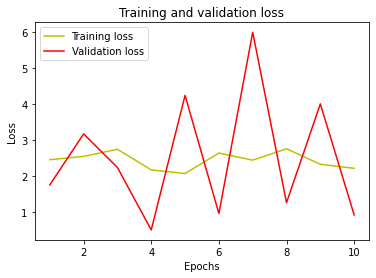

In [ ]:
history = vgg16_data
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from keras.applications.resnet import ResNet50

In [ ]:
resnet = ResNet50(input_shape=[224,224,3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(resnet.output)
prediction = Dense(1, activation='sigmoid')(x)

In [ ]:
model_resnet = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
resnet_model=model_resnet.compile(
  loss='BinaryCrossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
resnet_50=model_resnet.fit(train_gen, epochs = 8, validation_data=(valid_gen),callbacks=[get_lr_callback()])

Epoch 1/8
57/57 [==============================] - 66s 1s/step - loss: 0.3869 - accuracy: 0.8694 - val_loss: 0.3854 - val_accuracy: 0.8704 - lr: 5.0000e-06
Epoch 2/8
57/57 [==============================] - 65s 1s/step - loss: 0.3872 - accuracy: 0.8694 - val_loss: 0.3872 - val_accuracy: 0.8704 - lr: 6.2400e-06
Epoch 3/8
57/57 [==============================] - 64s 1s/step - loss: 0.3878 - accuracy: 0.8694 - val_loss: 0.3873 - val_accuracy: 0.8704 - lr: 7.4800e-06
Epoch 4/8
57/57 [==============================] - 64s 1s/step - loss: 0.3877 - accuracy: 0.8694 - val_loss: 0.3872 - val_accuracy: 0.8704 - lr: 8.7200e-06
Epoch 5/8
57/57 [==============================] - 64s 1s/step - loss: 0.3879 - accuracy: 0.8694 - val_loss: 0.3873 - val_accuracy: 0.8704 - lr: 9.9600e-06
Epoch 6/8
57/57 [==============================] - 64s 1s/step - loss: 0.3873 - accuracy: 0.8694 - val_loss: 0.3882 - val_accuracy: 0.8704 - lr: 1.1200e-05
Epoch 7/8
57/57 [==============================] - 63s 1s/step -

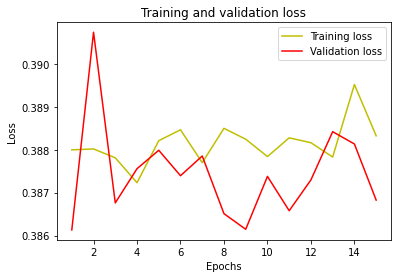

In [ ]:
history = resnet_50
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()